# Funciones Auxiliares

In [1]:
# Librerias para colab (QUITAR SI ES NECESARIO Y 
# CAMBIAR cv2_imshow por cv2.imshow)
from google.colab.patches import cv2_imshow

In [2]:
def names_generator(n_names=1, s='', format='.pgm' ):
    """
    Generador de nombres de archivos {i.format}, i=1,...,n_images.
    Args:
        n_names (int): Cantidad de nombres a generar.
        s (string): Cadena extra que se quiera agregar al nombre.
        format (string): Formato del archivo.
    Ejemplos:
        names_generator(5) = ('1.pgm', '2.pgm', '3.pgm', '4.pgm', '5.pgm')
        names_generator(2, '_gt', 'jpg') = ('1_gt.jpg', '2_gt.jpg')
        names_generator(2, '_gt') = ('1_gt.pgm', '2_gt.pgm')
        names_generator() = ('1.pgm')
    """
    names = range(n_names)
    
    for name in names:
        path = str(name + 1) + s + format
 
        yield path

In [3]:
import matplotlib.pyplot as plt

def print_images(images, titles, n, m):
    """
    Imprime las imagenes con su correspondiente titulo en un grid de n por m
    Args:
        images (list(np.ndarray)): Imagenes a imprimir.
        titles (list(str)): Cadena extra que se quiera agregar al nombre.
        n (int): Cantidad de filas de imagenes.
        m (int): Cantidad de columnas de imagenes.
    """
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(n, m, i+1), plt.imshow(image,'gray',vmin=0,vmax=255)
        plt.title(titles)
        plt.xticks([]), plt.yticks([])
    plt.show()

# Métodos de Umbralización

* Ridler Calvard
* Moment Preserving

## Ridler Calvard

In [4]:
def ridler_calvard(image, steps = 16):
    """
    Metodo de Umbralizacion Ridler-Calvard
    Args:
        image (np.ndarray): Imagen a segmentar
        steps (int): Numero de veces a iterar
    
    # Normalizacion de la imagen
    image = cv2.normalize(
        image, None, 
        alpha=0, beta=1, 
        norm_type=cv2.NORM_MINMAX, 
        dtype=cv2.CV_32F
    )
    """
    # 1. Seleccionamos un valor inicial de T
    T = np.mean(image)
    while steps > 0:
        # 2. Segmentamos imagen usando T
        ret, thresh = cv2.threshold(
            image, T, 255,
            cv2.THRESH_BINARY
        )
        # 3. Obtenemos dos clases de pixeles B y F
        B = image[np.where(thresh == 0)]
        F = image[np.where(thresh == 255)]
        # 4. Calculamos intensidades medias
        mu_B, mu_F = np.mean(B), np.mean(F)
        # 5. Actualizamos T
        T = np.mean([mu_B, mu_F])
        steps -= 1    
    #print("T : " + str(T))
    # 6. Usamos T final para umbralizar
    ret, thresh = cv2.threshold(
        image, T, 255,
        cv2.THRESH_BINARY
    )
    return thresh

## Moment Preserving
Se considera la imagen de nivel de gris como la versión borrosa de una imagen binaria ideal. El umbral se establece de modo que los tres primeros momentos del nivel de grises coincidan con los tres primeros momentos de la imagen binaria. Los momentos de nivel de gris y los momentos de imagen binaria bk se definen, respectivamente, como:
$$
    m_k = \sum_{g} p(g)g^{k}\\
    b_k = P_{f}m_{f}^{k} + P_{b}m_{b}^{k}
$$

In [5]:
def calculate_t(image):

    n = image.shape[0]*image.shape[1]

    # Calculo de histograma normalizado
    hist = cv2.calcHist([image],[0],None,[256],[0,256])
    hist_norm = hist.ravel()/hist.sum()

    # Calculo de momentos
    m_i = [1.0, 0.0, 0.0, 0.0]
    for j, p_j in enumerate(hist_norm):
        for i in range(1, 4):
            m_i[i] += p_j * (j ** i)

    # Calculo de soluciones a c_0 y c_1
    c_d = np.linalg.det(np.array([
        [m_i[0], m_i[1]],
        [m_i[1], m_i[2]]
    ]))

    c_0 = np.linalg.det(np.array([
        [-m_i[2], m_i[1]],
        [-m_i[3], m_i[2]]
    ]))
    c_0 *= (1 / c_d)

    c_1 = np.linalg.det(np.array([
        [m_i[0], -m_i[2]],
        [m_i[1], -m_i[3]]
    ]))
    c_1 *= (1 / c_d)

    # Calculo de soluciones a z_0 y z_1
    z_0 = (0.5) * (-c_1 - np.sqrt(c_1**2 - 4*c_0))
    z_1 = (0.5) * (-c_1 + np.sqrt(c_1**2 - 4*c_0))
    
    # Calculo de soluciones de p_0 y p_1
    p_d = np.linalg.det(np.array([
        [1.0, 1.0],
        [z_0, z_1]
    ]))

    p_0 = np.linalg.det(np.array([
        [   1.0, 1.0],
        [m_i[1], z_1]
    ]))
    p_0 *= (1 / p_d)
    p_1 = 1 - p_0

    # Calculamos T
    t = np.quantile(image, p_0)
    
    return t

def moment_preserving(image):

    # 1. Calculamos T que preserva primeros 3 momentos
    T = calculate_t(image)
    #print("T: " + str(T))
    # 2. Usamos T final para umbralizar
    ret, thresh = cv2.threshold(
        image, T, 255,
        cv2.THRESH_BINARY
    )
    return thresh

# Métricas

* Sensitivity
* Accuracy
* Misclassification error 
* Positive predictive value
* Negative predictive value
* Jaccard index
* Dicecoefficient

In [6]:
def sensitivity(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return tp / (tp + fn)

def specificity(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return tn / (tn + fp)

def accuracy(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return (tp + tn) / (tp + tn + fp + fn)

def misclassification_error(matrix):
    return 1 - accuracy(matrix)

def positive_predictive_value(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return tp / (tp + fp)

def negative_predictive_value(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return tn / (tn + fn)

def jaccard_index(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return tp / (tp + fp + fn)

def dice_coefficient(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return (2*tp) / ( 2*tp + fp + fn)

# Imágenes
La actual base de datos (DCA1) consta de 134 angiogramas coronarios de rayos X y su correspondiente imagen Ground-Truth esbozada por un cardiólogo experto. Cada angiograma es una imagen en escala de grises de 300 x 300 píxeles en formato pgm (mapa de grises portátil).

In [7]:
# SE PUEDE OMITIR ESTA CELDA. EN ESE CASO EJECUTAR DENTRO DEL DIRECTORIO
# DE LAS IMAGENES
import numpy as np
import cv2

from google.colab import drive
drive.mount('/content/drive')

import sys, os
path = "/content/drive/My Drive/Colab Notebooks/data/Database_134_Angiograms/"
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


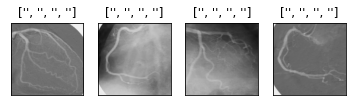

In [8]:
file_path = names_generator(134)

images = []
for path in file_path:
    # Lectura de la imagen
    image = cv2.imread(
        path, 
        cv2.IMREAD_UNCHANGED
    )
    # Convertimos al negativo de la imagen
    image = cv2.bitwise_not(image)
    # Agregamos imagen a lista de imagenes
    images.append(image)

print_images(images[11:15], ['', '', '', ''], 1, 4)

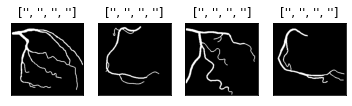

In [9]:
file_path = names_generator(134, '_gt')

images_gt = []
for path in file_path:
    # Lectura de la imagen
    image = cv2.imread(
        path, 
        cv2.IMREAD_UNCHANGED
    )
    # Agregamos imagen a lista de imagenes
    images_gt.append(image)

print_images(images_gt[11:15], ['', '', '', ''], 1, 4)

In [10]:
for i, image_gt in enumerate(images_gt):
    aux = dict({})
    for row in image_gt:
        for element in row:
            aux[str(element)] = 1
    if len(aux) != 2:
        print("G_T no binario con indice: " + str(i))

G_T no binario con indice: 43
G_T no binario con indice: 65
G_T no binario con indice: 69
G_T no binario con indice: 72
G_T no binario con indice: 78


# Umbralizacion de Imágenes

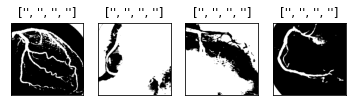

In [11]:
images_t1 = []
for image in images:
    T1, T2 = 80, 125
    #print("T : " + str(T1) + " " + str(T2))
    ret, thresh1 = cv2.threshold(
        image, T1, 255,
        cv2.THRESH_BINARY
    )
    ret, thresh2 = cv2.threshold(
        image, T2, 255,
        cv2.THRESH_BINARY
    )      
    images_t1.append(255 - (thresh1 - thresh2))  

print_images(images_t1[11:15], ['', '', '', ''], 1, 4)

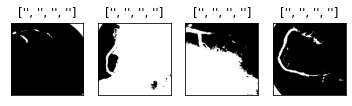

In [12]:
images_otsu = []
for image in images:
    ret, thresh = cv2.threshold(
        image, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )      
    images_otsu.append(thresh)  

print_images(images_otsu[11:15], ['', '', '', ''], 1, 4)

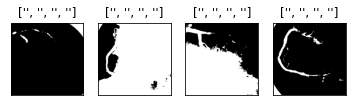

In [13]:
images_RC = []
for image in images:
    thresh = ridler_calvard(image)
    images_RC.append(thresh)

print_images(images_RC[11:15], ['', '', '', ''], 1, 4)

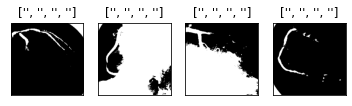

In [14]:
images_mp = []
for image in images:
    thresh = moment_preserving(image)
    images_mp.append(thresh)

print_images(images_mp[11:15], ['', '', '', ''], 1, 4)

# Indices de desempeño

In [15]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(image_gt, image_si):
    
    y_true = image_gt.reshape(-1)
    y_pred = image_si.reshape(-1)

    matrix = confusion_matrix(y_true, y_pred, labels=[0, 255])

    return matrix

In [16]:
def performance_indices(images_gt, images_si):
    sensitivity_list = []
    specificity_list = []
    accuracy_list = []
    misclassification_list = []
    ppv_list = []
    npv_list = []
    jaccard_list = []
    dice_list = []

    for i, (image_gt, image_si) in enumerate(zip(images_gt, images_si)):
        # Obtenemos tabla de clasificacion
        matrix = get_confusion_matrix(image_gt, image_si)
        # Metricas ...
        sensitivity_list.append(sensitivity(matrix))
        specificity_list.append(specificity(matrix))
        accuracy_list.append(accuracy(matrix))
        misclassification_list.append(misclassification_error(matrix))
        ppv_list.append(positive_predictive_value(matrix))
        npv_list.append(negative_predictive_value(matrix))
        jaccard_list.append(jaccard_index(matrix))
        dice_list.append(dice_coefficient(matrix))
        # Tabla de clasificacion de cada imagen
        """print("Accuracy in image i: ")
        print(accuracy(matrix))
        print("")"""

    print("")
    print("Sensitivity : " + str(np.mean(sensitivity_list)))
    print("Specificity : " + str(np.mean(specificity_list)))
    print("Accuracy : " + str(np.mean(accuracy_list)))
    print("Misclassification : " + str(np.mean(misclassification_list)))
    print("PPV : " + str(np.mean(ppv_list)))
    print("NPV : " + str(np.mean(npv_list)))
    print("jaccard Index : " + str(np.mean(jaccard_list)))
    print("Dice Coefficient: " + str(np.mean(dice_list)))
    print("")

In [17]:
print("Umbral en dos niveles :")
performance_indices(images_gt, images_t1)
print("Umbral por Moment Preserving :")
performance_indices(images_gt, images_mp)
print("Umbral R.C. :")
performance_indices(images_gt, images_RC)
print("Umbral Otsu :")
performance_indices(images_gt, images_otsu)

Umbral en dos niveles :

Sensitivity : 0.7780357728532276
Specificity : 0.4160751917680094
Accuracy : 0.4341838151387524
Misclassification : 0.5658161848612475
PPV : 0.13312435934692526
NPV : 0.9531799015895185
jaccard Index : 0.12043354181436966
Dice Coefficient: 0.19344436633931872

Umbral por Moment Preserving :

Sensitivity : 0.6583062382309597
Specificity : 0.6248591714079619
Accuracy : 0.6258231624137632
Misclassification : 0.3741768375862368
PPV : 0.15967633128979847
NPV : 0.9716266553540088
jaccard Index : 0.12978664525148956
Dice Coefficient: 0.2107082045952661

Umbral R.C. :

Sensitivity : 0.6547206795867022
Specificity : 0.5939359764541278
Accuracy : 0.5967583867547267
Misclassification : 0.4032416132452733
PPV : 0.1275679759077212
NPV : 0.9720154575064448
jaccard Index : 0.11223730235277525
Dice Coefficient: 0.17970915116992037

Umbral Otsu :

Sensitivity : 0.6458210607664013
Specificity : 0.5996272601083895
Accuracy : 0.6016295300788256
Misclassification : 0.39837046992117

# Histogramas de Imágenes

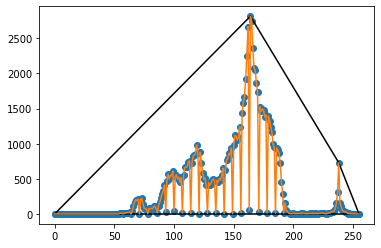

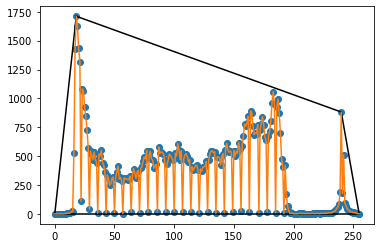

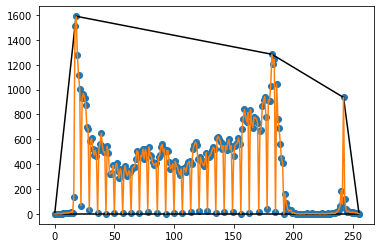

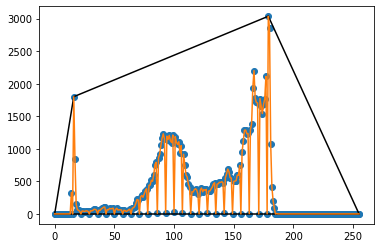

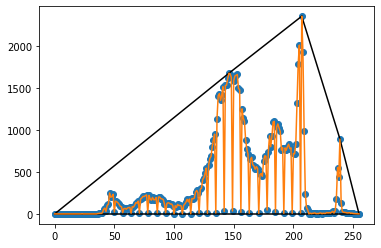

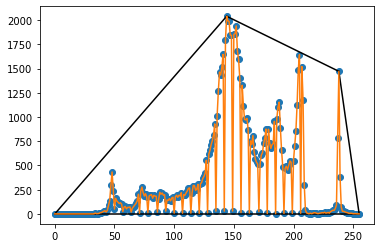

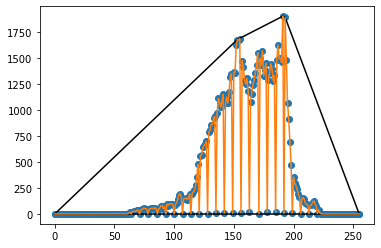

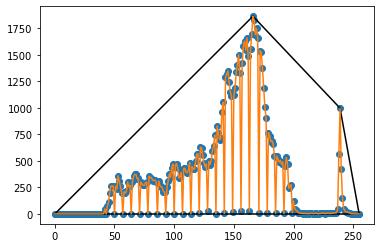

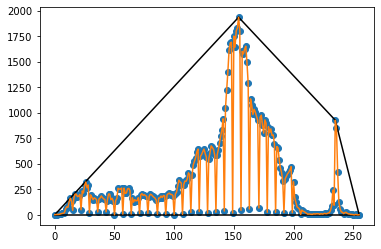

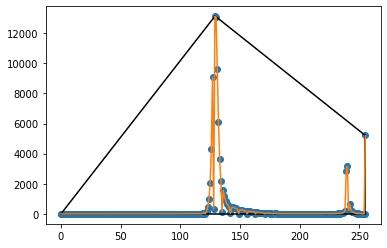

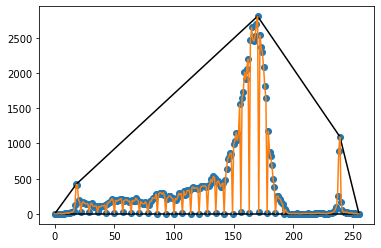

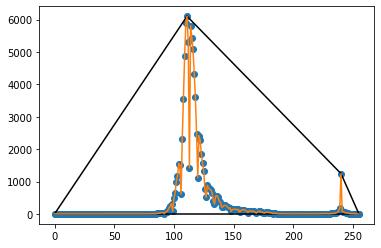

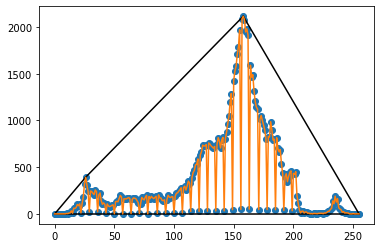

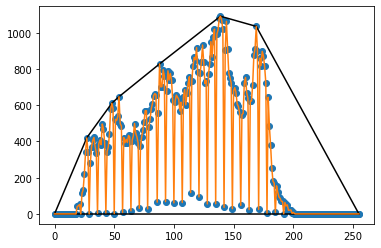

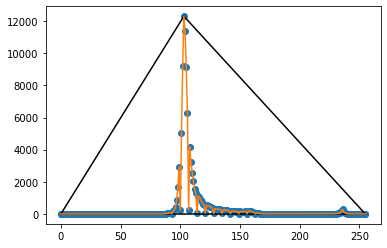

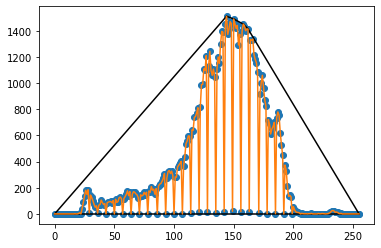

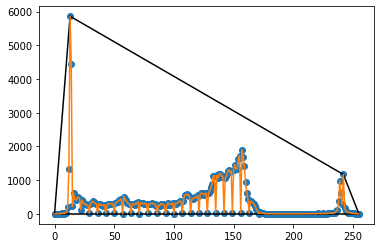

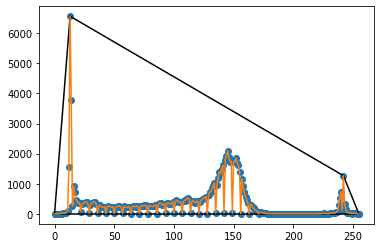

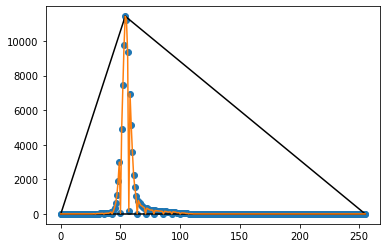

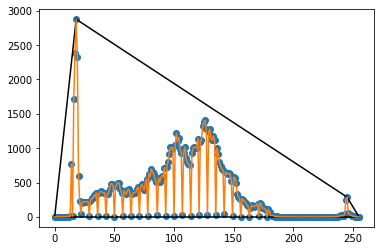

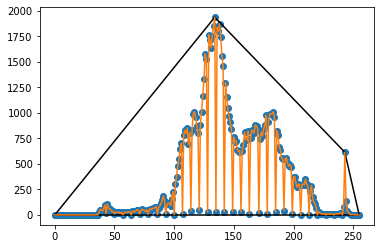

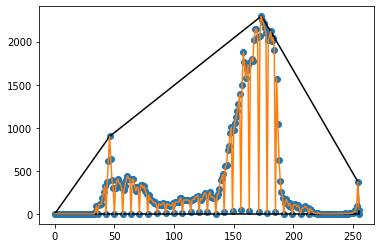

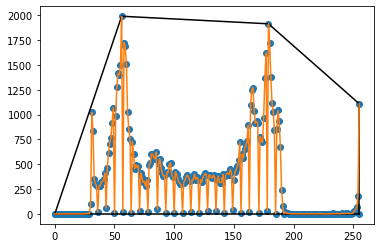

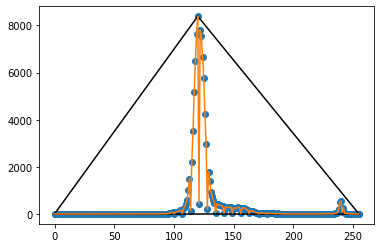

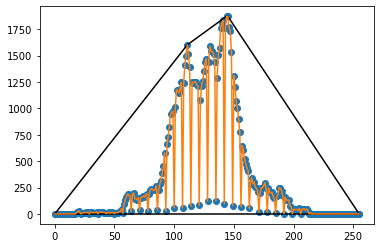

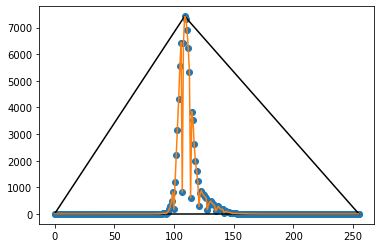

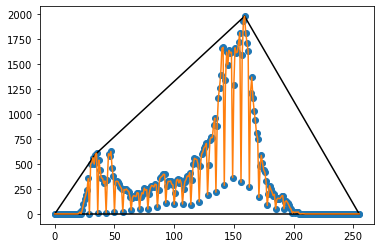

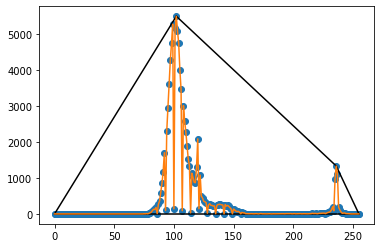

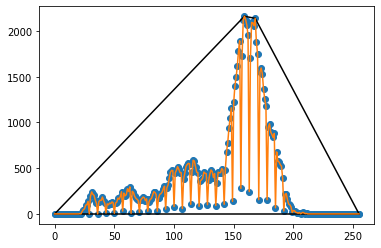

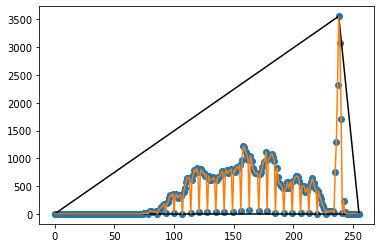

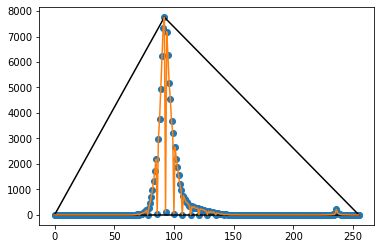

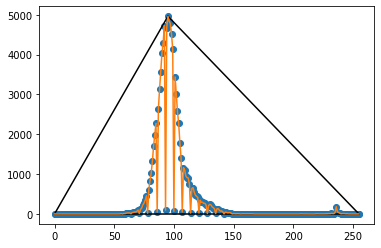

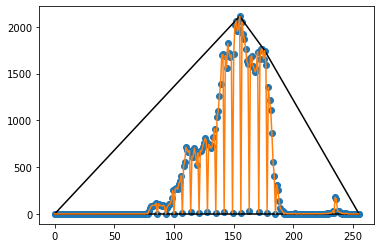

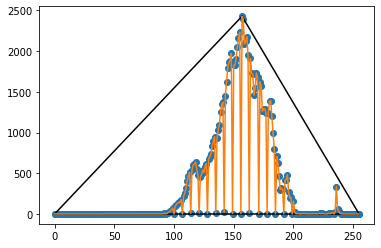

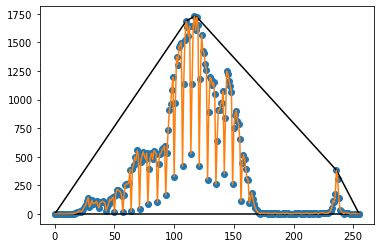

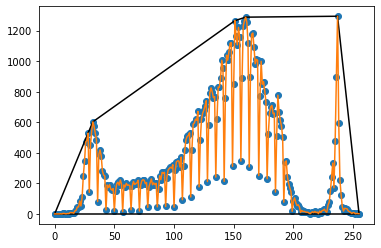

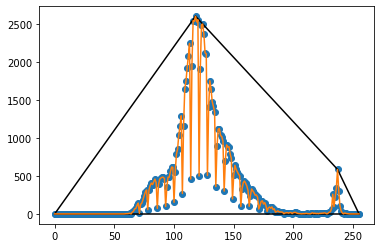

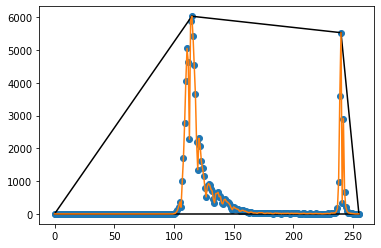

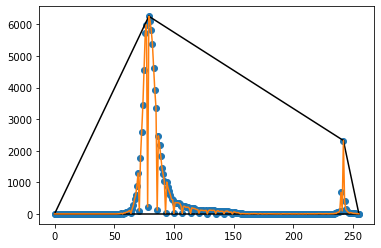

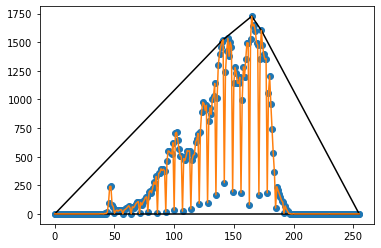

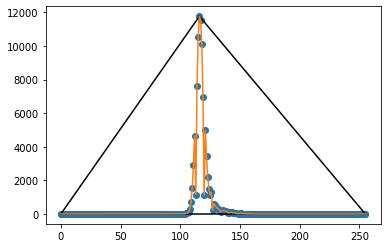

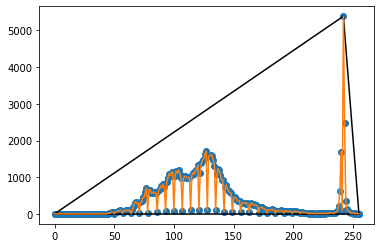

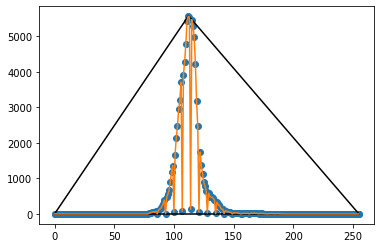

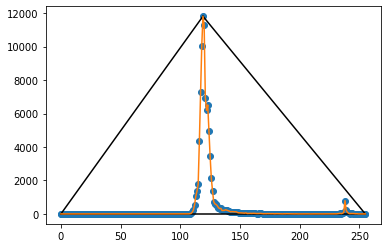

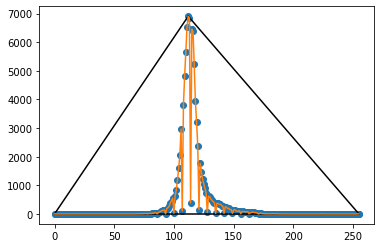

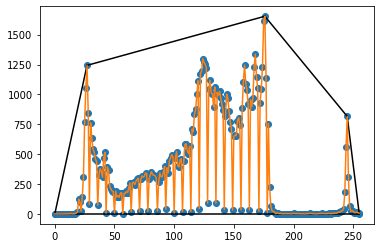

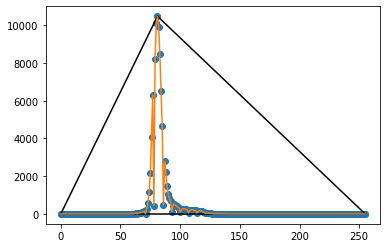

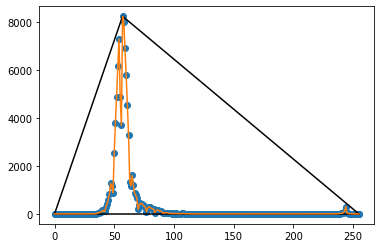

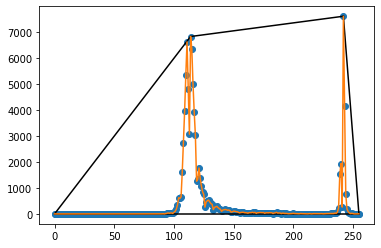

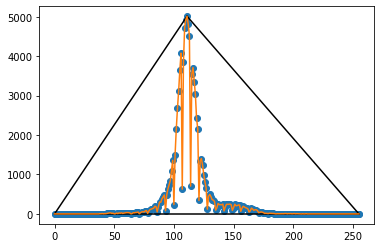

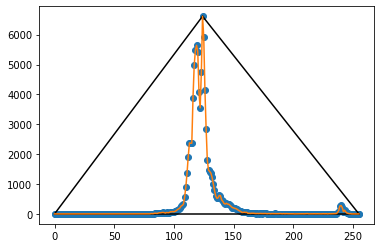

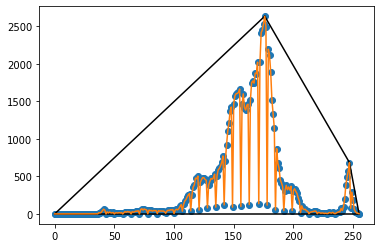

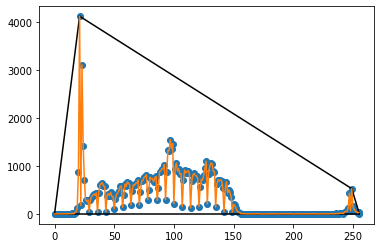

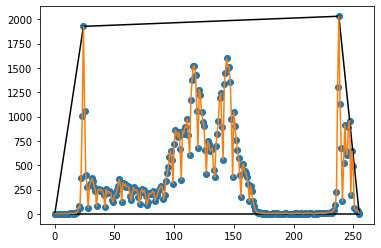

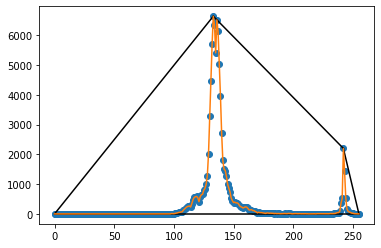

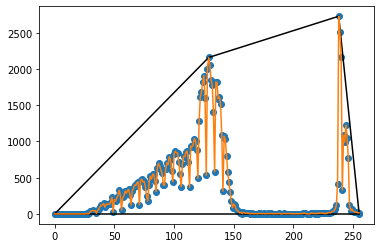

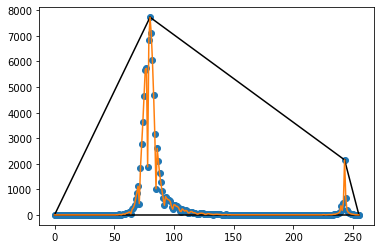

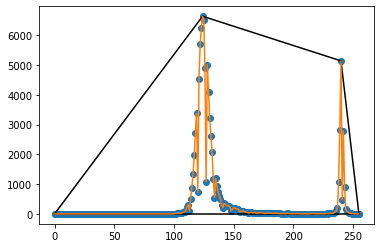

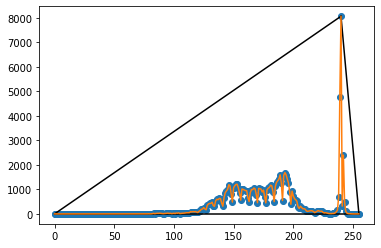

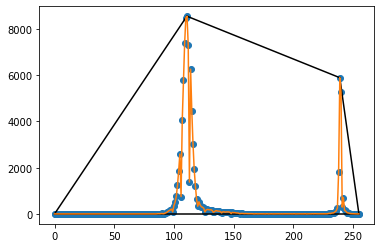

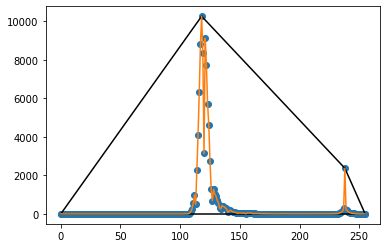

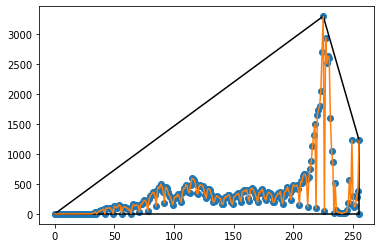

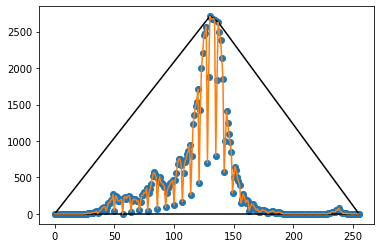

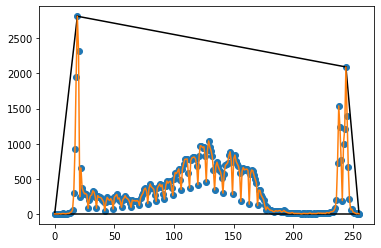

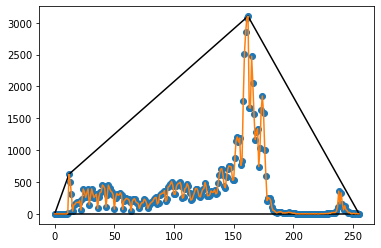

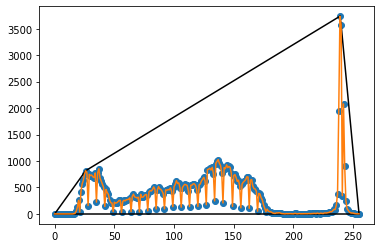

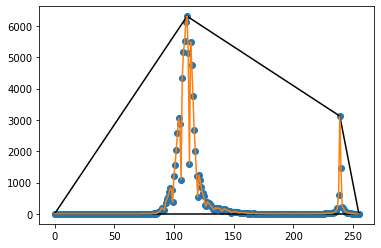

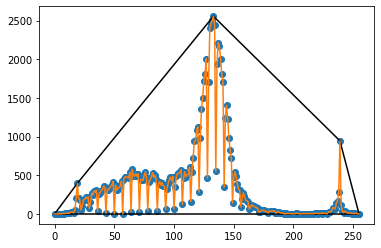

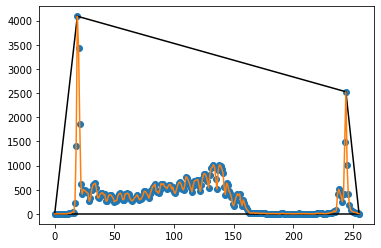

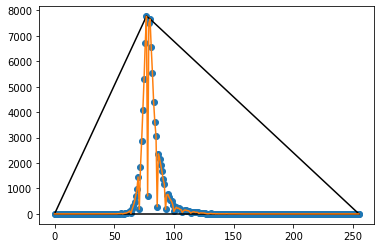

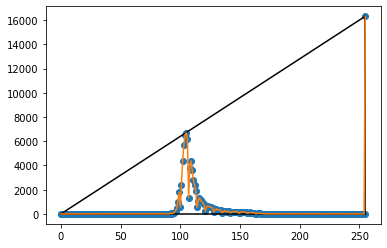

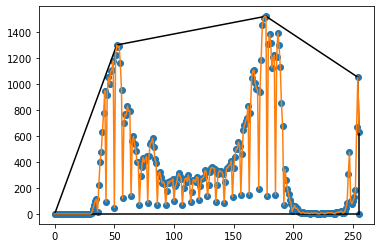

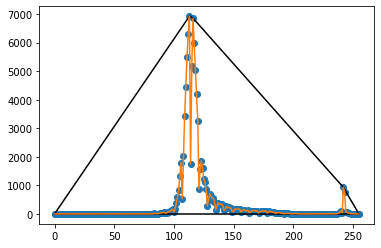

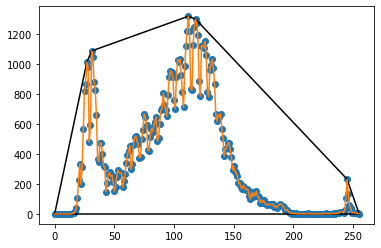

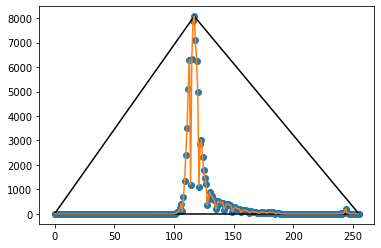

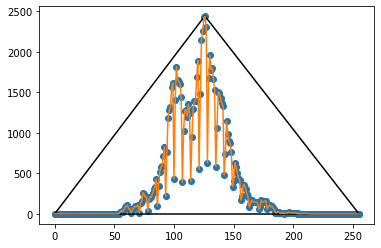

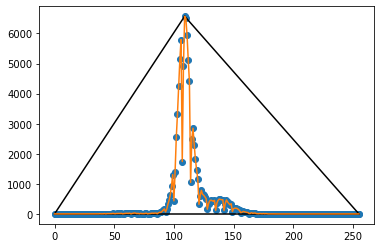

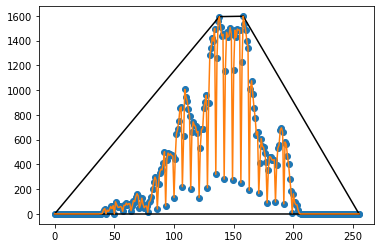

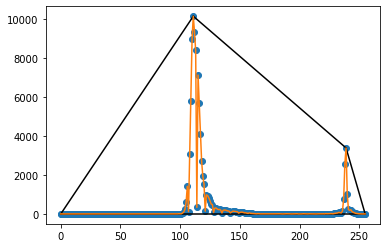

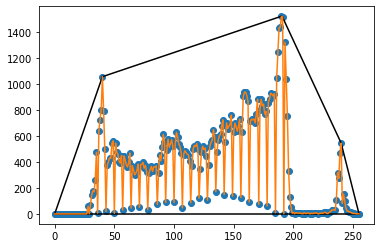

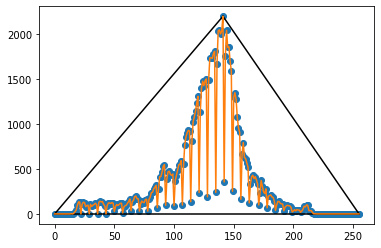

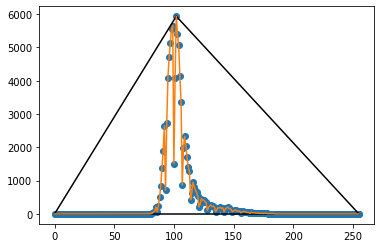

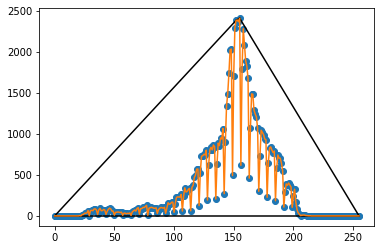

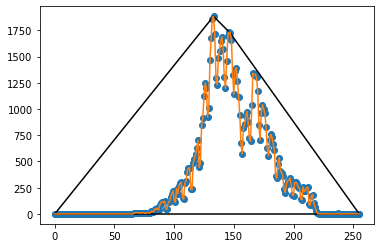

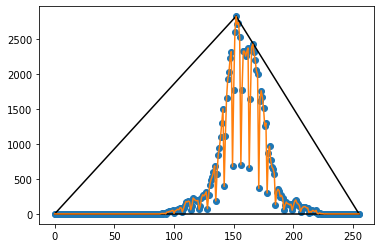

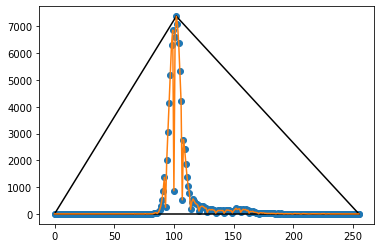

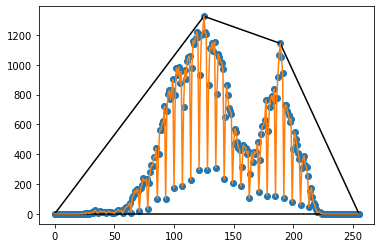

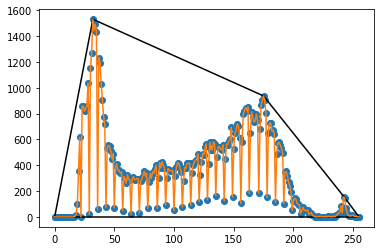

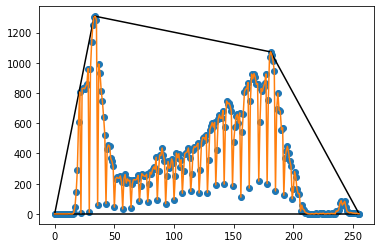

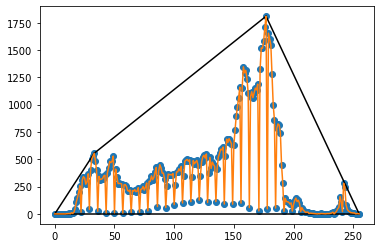

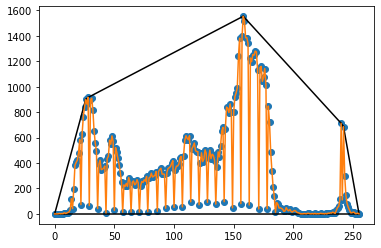

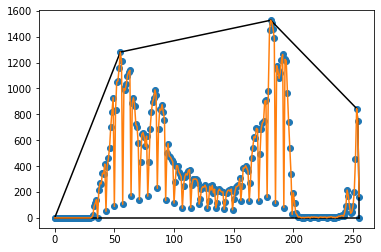

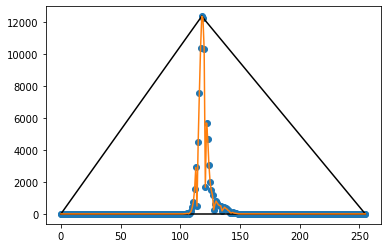

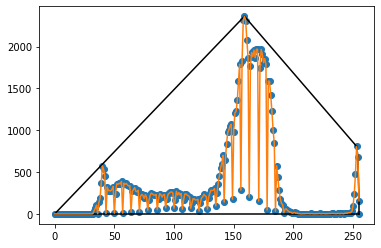

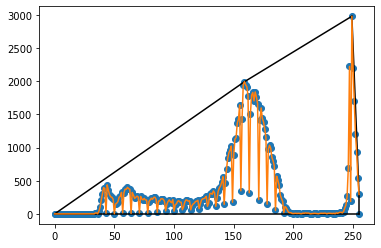

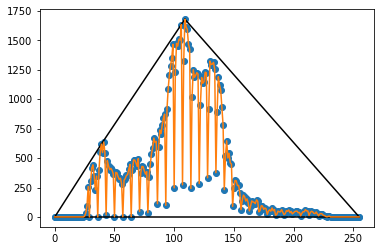

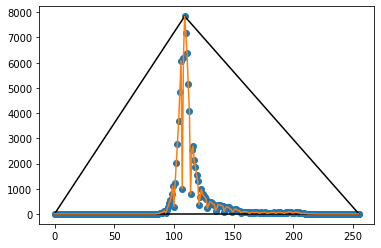

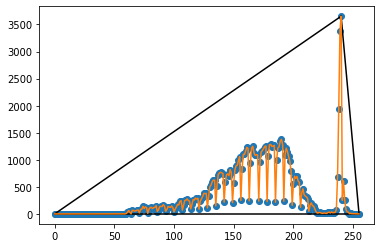

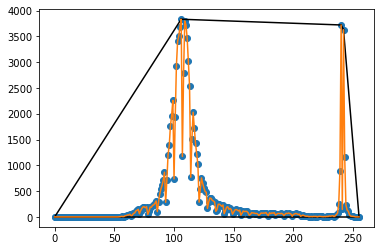

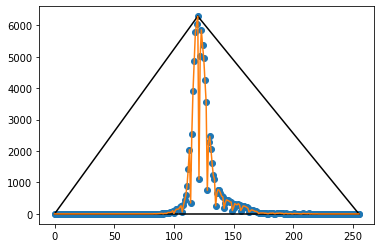

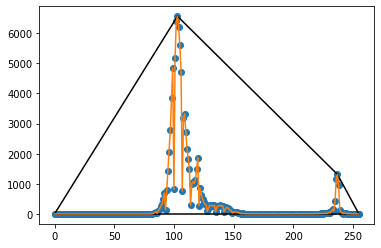

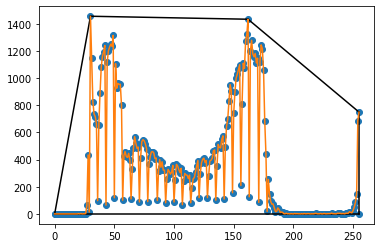

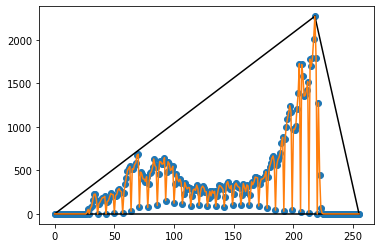

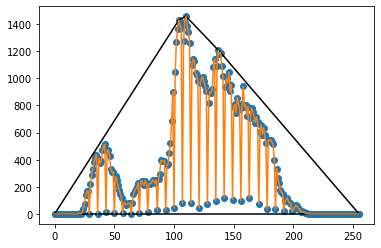

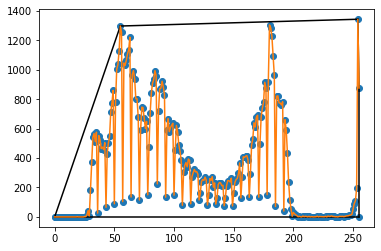

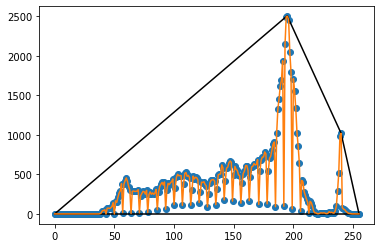

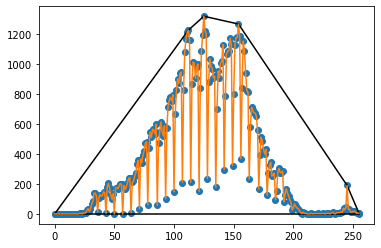

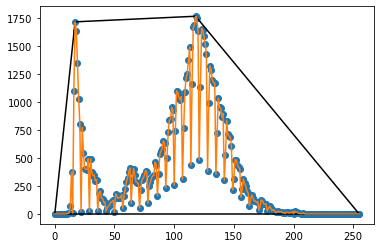

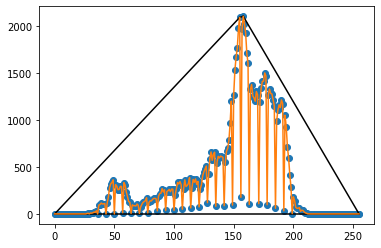

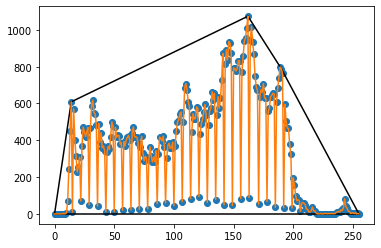

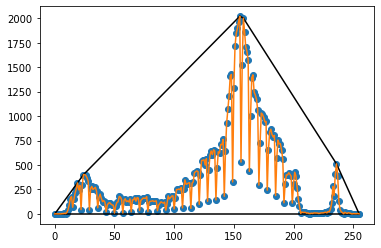

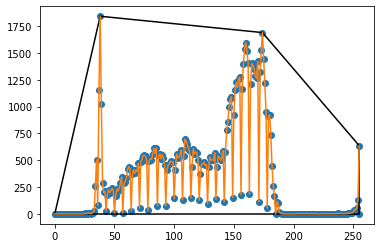

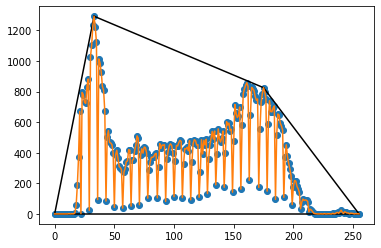

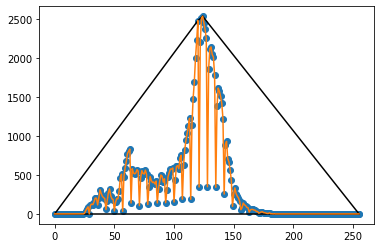

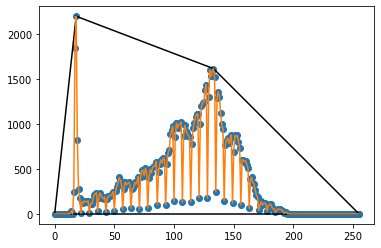

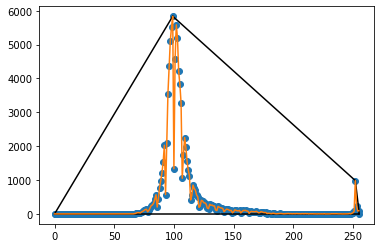

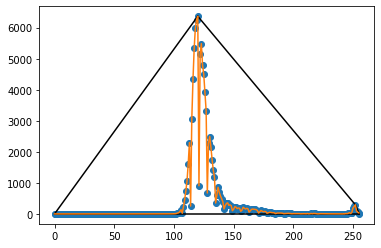

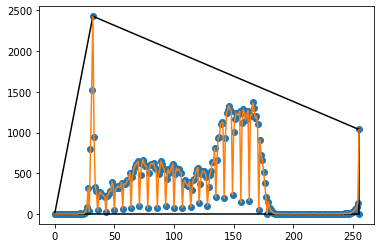

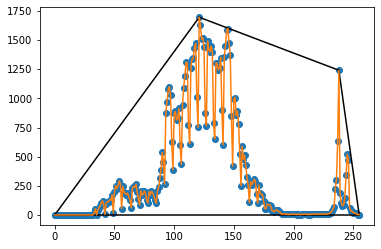

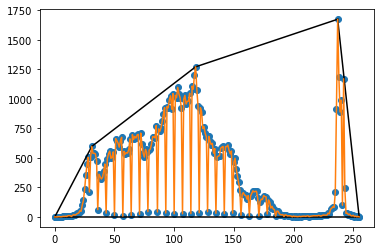

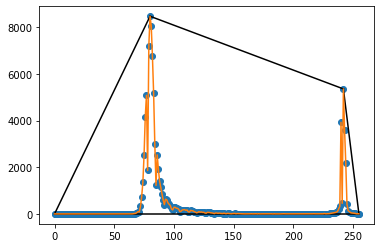

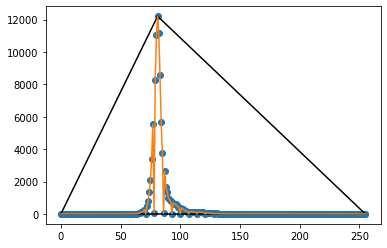

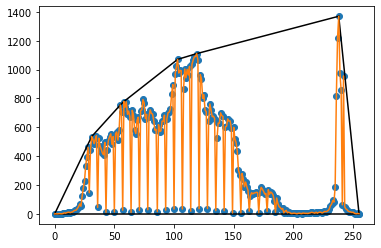

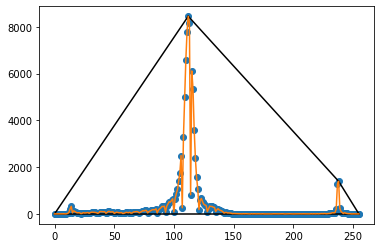

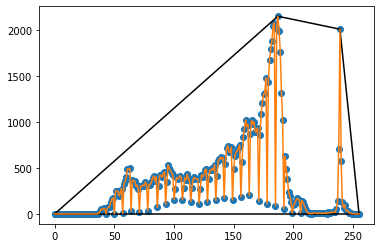

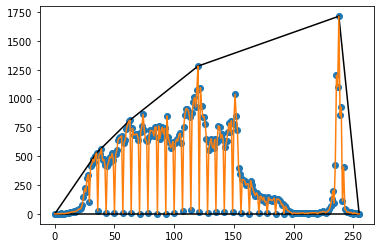

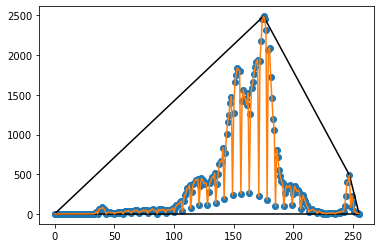

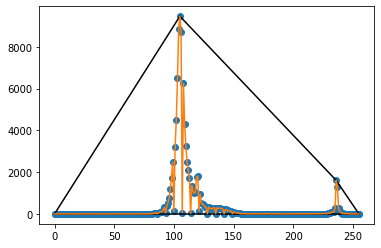

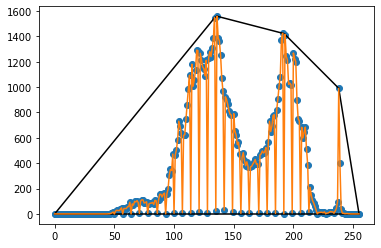

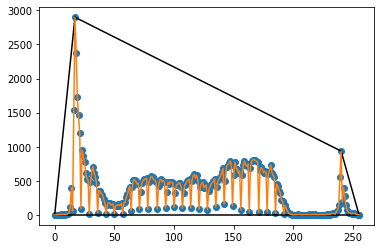

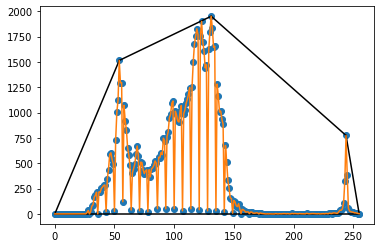

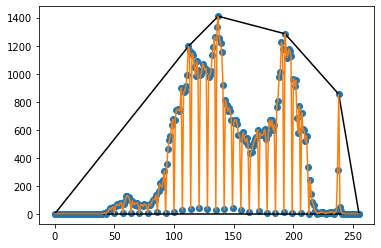

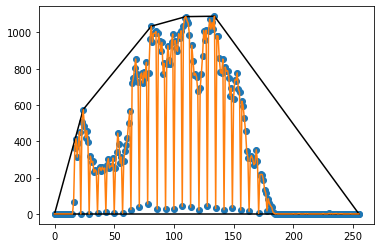

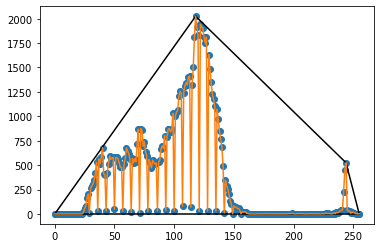

In [18]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

for image in images:
    
    hist = cv2.calcHist([image],[0],None,[256],[0,256])
    
    points = [[0.0, 0.0]]
    for i, h in enumerate(hist.reshape(-1)):
        points.append([i, h])
    points.append([255.0, 0.0])
    points = np.array(points)

    hull = ConvexHull(points)

    plt.plot(points[:,0], points[:,1], 'o')
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')


    plt.plot(hist)
    plt.show()